# Variational Autoencoders 

## Architecture

Architecturally, the difference between a VAE and an AE is that while the encoder in the AE directly outputs the encoded image, in a VAE it outputs mean and stdv values from which we can sample 

In [280]:
import torch
import torch.nn as nn
import torch.nn.functional as F

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(device)


mps


In [281]:

class ConvolutionalVAE(nn.Module):
    def __init__(
        self,
        input_dim: int,
        n_channels: int,
        latent_dim: int,
    ):
        super().__init__()
        
        self.latent_dim = latent_dim
        
        self.encoder = nn.Sequential(
            nn.Conv2d(n_channels, 96, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(96),
            nn.Conv2d(96, 192, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(192),
            nn.Conv2d(192, 384, kernel_size=3, stride=2, padding=1), 
            nn.ReLU(),
            nn.BatchNorm2d(384),
            nn.Flatten(),
            nn.Linear(384 * input_dim[1] // 8 * input_dim[2] // 8, 2 * latent_dim),
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 384 * input_dim[1] // 8 * input_dim[2] // 8),
            nn.Unflatten(1, (384, input_dim[1] // 8, input_dim[2] // 8)),
            nn.ConvTranspose2d(384, 192, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(192),
            nn.ConvTranspose2d(192, 96, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(96),
            nn.ConvTranspose2d(96, n_channels, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid(),
        )
        
    def sample(self, mu: torch.Tensor, logvar: torch.Tensor) -> torch.Tensor:
        """
        Sample from the latent space using the reparameterization trick.

        Args:
            mu: mean of the latent space
            logvar: log variance of the latent space

        Returns:
            z: sampled latent space
        """
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass through the VAE.

        Args:
            x: input data

        Returns:
            x_hat: reconstructed data
        """
        encoded = self.encoder(x)
        mu, logvar = encoded.split(self.latent_dim, dim=1)
        z = self.sample(mu, logvar)
        return self.decoder(z), (mu, logvar)

In [282]:
# Checking that dimenionality is correct
vae = ConvolutionalVAE(
    input_dim=(3, 32, 32),
    n_channels=3,
    latent_dim=128,
)

random_data = torch.randn(4, 3, 32, 32)
x_hat, (mu, logvar) = vae(random_data)

print("x_hat shape", x_hat.shape)
print("mean shape", mu.shape)
print("logvar shape", logvar.shape)

x_hat shape torch.Size([4, 3, 32, 32])
mean shape torch.Size([4, 128])
logvar shape torch.Size([4, 128])


## Objective function

So we've adjusted the architecture and added in the sampling/reparameterization trick to allow the flow of gradients. What's left?

the other difference between the VAE and the AE is the loss function. our loss term consists of two parts now, reconstruction and KL
divergence of the latent distribution from a standard normal distribution

In [283]:
def validate(model, reconstruction_loss_func, valid_dl, beta=1):
    model.eval()
    with torch.no_grad():
        tot_loss = 0.
        tot_recon_loss = 0.
        tot_kl_loss = 0.
        num_batches = 0
        for xb, _ in valid_dl:
            x_hat, (mu, logvar) = model(xb)
            recon_loss = reconstruction_loss_func(x_hat, xb)
            kl_loss = kl_loss_func(mu, logvar)
            loss = recon_loss + beta * kl_loss  # apply beta weighting to balance regularization and reconstruction loss
            
            tot_loss += loss.item()
            tot_recon_loss += recon_loss.item()
            tot_kl_loss += kl_loss.item()
            num_batches += 1

    return tot_loss / num_batches, tot_recon_loss / num_batches, tot_kl_loss / num_batches

def kl_loss_func(mu, logvar):
    # Clamp logvar for numerical stability
    logvar = torch.clamp(logvar, -10, 10)
    
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return kl_loss / (mu.size(0) * mu.size(1)) # normalize to prevent explosion

def fit(
    epochs, 
    model,
    reconstruction_loss_func, 
    opt, 
    train_dl, 
    valid_dl,
    beta=1,
    grad_clip=1.0
):
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        model.train()
        for xb,yb in train_dl:
            x_hat, (mu, logvar) = model(xb)
            recon_loss = reconstruction_loss_func(x_hat, xb)
            kl_loss = kl_loss_func(mu, logvar)
            loss = recon_loss + beta * kl_loss  # Apply β weighting
            
            opt.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
            opt.step()


        total_loss, recon_loss, kl_loss = validate(model, reconstruction_loss_func, valid_dl, beta)
        print(f"Validation loss: {total_loss:.6f}")
        print(f"Reconstruction loss: {recon_loss:.6f}")
        print(f"KL loss: {kl_loss:.6f}")


## Data boiler plate

In [284]:
import pickle
import numpy as np
import torch


all_batches_data = []
all_batches_labels = []

for i in range(1, 6):
    with open(f'data/cifar-10-batches-py/data_batch_{i}', 'rb') as f:
        dataset_dict = pickle.load(f, encoding='bytes')
        all_batches_data.append(dataset_dict[b'data'])
        all_batches_labels.append(dataset_dict[b'labels'])

stacked_data = np.vstack(all_batches_data)
stacked_labels = np.hstack(all_batches_labels)
data = torch.tensor(stacked_data, dtype=torch.float32).view(-1, 3, 32, 32).to(device) / 255.
labels = torch.tensor(stacked_labels, dtype=torch.long).to(device)

split_idx = int(0.8 * len(data))

x_train, x_valid = data[:split_idx], data[split_idx:]
y_train, y_valid = labels[:split_idx], labels[split_idx:]

from torch.utils.data import Dataset, DataLoader

class CIFARCustomDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

train_ds = CIFARCustomDataset(x_train, y_train)
valid_ds = CIFARCustomDataset(x_valid, y_valid)

train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=32, shuffle=True)

## Train

In [286]:
model = ConvolutionalVAE(
    input_dim=(3, 32, 32),
    n_channels=3,
    latent_dim=128,
)

reconstruction_loss_func = nn.MSELoss()
opt = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-5)

model.to(device)

fit(100, model, reconstruction_loss_func, opt, train_dl, valid_dl, beta=0.001)

Epoch 1/100
Validation loss: 0.010172
Reconstruction loss: 0.007969
KL loss: 2.202168
Epoch 2/100
Validation loss: 0.018015
Reconstruction loss: 0.006237
KL loss: 11.778009
Epoch 3/100
Validation loss: 0.009682
Reconstruction loss: 0.005758
KL loss: 3.924230
Epoch 4/100
Validation loss: 0.012722
Reconstruction loss: 0.005563
KL loss: 7.158377
Epoch 5/100
Validation loss: 0.007233
Reconstruction loss: 0.005456
KL loss: 1.777084
Epoch 6/100
Validation loss: 0.007953
Reconstruction loss: 0.006139
KL loss: 1.813407
Epoch 7/100
Validation loss: 0.007282
Reconstruction loss: 0.005565
KL loss: 1.716720
Epoch 8/100
Validation loss: 0.008178
Reconstruction loss: 0.005528
KL loss: 2.650188
Epoch 9/100
Validation loss: 0.007699
Reconstruction loss: 0.005500
KL loss: 2.199640
Epoch 10/100
Validation loss: 0.007184
Reconstruction loss: 0.005547
KL loss: 1.637458
Epoch 11/100
Validation loss: 0.007052
Reconstruction loss: 0.005414
KL loss: 1.637540
Epoch 12/100
Validation loss: 0.006897
Reconstructi

In [287]:
import numpy as np
import matplotlib.pyplot as plt

def show_torch_image(img):
    img = img.permute(1, 2, 0)
    img = img.numpy().astype(np.uint8)

    plt.imshow(img)
    plt.axis('off')
    plt.show()

torch.Size([1, 3, 32, 32])


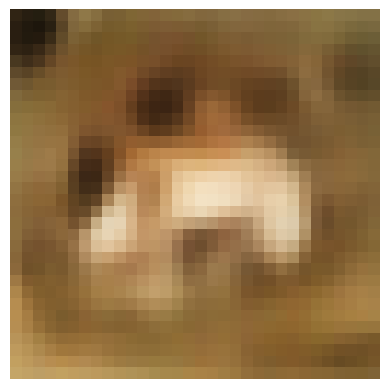

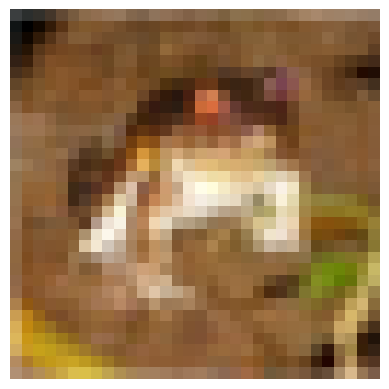

In [288]:
sample_output, (mu, logvar) = model(x_train[0].unsqueeze(0))
print(sample_output.shape)
show_torch_image(255*sample_output.squeeze(0).detach().cpu())
show_torch_image(255 * x_train[0].cpu())

## Some learnings so far

- VAEs are a lot more sensitive to hyperparameters due to the existence of multiple loss terms. Ideally, we might want to put our hparam beta on a schedule. 
- VAEs are regularized and therefore generalize in distribution better than AEs that inherently overfit to their training dataset 
- We can see the smoothness problem that led to the introduction of VQ-VAEs above
- VAEs take a lot more time to train because: 
    1. There are more layers/parameters 
    2. The reparameterization trick adds some complexity to how gradients flow 
    3. There is a dance going on between loss functions 

## Some things we can do to improve performance 

- Instead of using a linear layer to output a flattened latent, we could use a conv layer to better represent spatial information 
- Train for longer 
- Use a beta scheduler for the b-vae implementation 
